# Vision Transformer (ViT) analyses

In [130]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import skimage

import sys, os
from datetime import datetime
from pathlib import Path

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras import Model

from vit_keras import vit, utils
from vit_keras import visualize

from keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import pickle

sys.path.insert(0, str(Path.cwd().parent.parent))
import leukopy_lib as leuko
from importlib import reload

reload(leuko)

<module 'leukopy_lib' from '/home/marie-anne/code/Leukopy/notebooks/leukopy_lib.py'>

# Set up

In [4]:
def find_layer(model: Model, layer_name: str) -> Model:
    for (i, layer) in enumerate(model.layers):
        if layer.name == layer_name:
            return (i, layer)
    
def model_surgery(model: Model):
    submodel_index, submodel = find_layer(model, 'vit-b16')
    x = submodel.outputs[0]
    for layer_index in range(submodel_index+1, len(model.layers)):
        extracted_layer = model.layers[layer_index]
        print('Surgically appending layer : '+str(extracted_layer))
        x = extracted_layer(x)
    new_model = Model(inputs=submodel.inputs, outputs=[x])
    return new_model


In [5]:
def plot_hist(hist):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.plot(hist['accuracy'], label='training')
    ax1.plot(hist['val_accuracy'], label='testing')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend()

    ax2.plot(hist['loss'], label='training')
    ax2.plot(hist['val_loss'], label='testing')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend()
    plt.close()

    return fig

In [6]:
def plot_confusion_matrix(df):
    plt.figure(figsize=(10,8))
    sns.heatmap(confusion_matrix(df_pred['true'], df_pred['pred'], normalize='true'), 
                annot=True, cmap='GnBu', square=True)
    plt.title('confusion matrix')
    plt.ylabel('True labels')
    plt.xlabel('Predicted label')
    plt.show()


In [7]:
def plot_attention(image, model):
    attention_map = visualize.attention_map(model = model, image = image)

    # Plot results
    fig, (ax1, ax2) = plt.subplots(ncols = 2)
    ax1.axis('off')
    ax2.axis('off')
    ax1.set_title('Original')
    ax2.set_title('Attention Map')
    _ = ax1.imshow(image.astype('uint8'))
    _ = ax2.imshow(attention_map)
    
    return fig

## Generate dataframes

In [8]:
INPUT_PATH = Path('../../../data/main_dataset/') #barcelone dataset

df_train = leuko.generate_images_df(INPUT_PATH/'training_set')
df_test = leuko.generate_images_df(INPUT_PATH/'testing_set')
df_valid = leuko.generate_images_df(INPUT_PATH/'validation_set')

In [9]:
N_CLASSES, df_train, df_test, df_valid = leuko.choose_classes(df_train, df_test, df_valid, n_classes = 11)

## Image generator

For ViT image are patched into [16x16](https://arxiv.org/abs/2010.11929) images ("images is worth 16x16 words")

In [10]:
BATCH_SIZE = 32
IMG_SIZE  = 224 #need to be a multiple of patch size = 16
EPOCHS = 100
LR = 1e-3

In [20]:
train_generator = ImageDataGenerator(rotation_range = 90,
                                     horizontal_flip = True, 
                                     vertical_flip = True)
valid_generator = ImageDataGenerator()
test_generator = ImageDataGenerator()

# Resize pictures, batchs from dataframe
training_set = train_generator.flow_from_dataframe(df_train, 
                                                   directory = None, # uses x_col
                                                   x_col = 'img_path', 
                                                   y_col = 'label',
                                                   target_size = (IMG_SIZE, IMG_SIZE), 
                                                   color_mode = 'rgb',
                                                   classes = None,   # uses y_col
                                                   class_mode = 'categorical', 
                                                   batch_size = BATCH_SIZE,
                                                   shuffle = True)

validation_set = valid_generator.flow_from_dataframe(df_valid, 
                                                     directory = None, # uses x_col
                                                     x_col = 'img_path', 
                                                     y_col = 'label',
                                                     target_size = (IMG_SIZE, IMG_SIZE), 
                                                     color_mode = 'rgb',
                                                     classes = None,   # uses y_col
                                                     class_mode = 'categorical', 
                                                     batch_size = BATCH_SIZE, 
                                                     shuffle = True)

testing_set = test_generator.flow_from_dataframe(df_test, 
                                                 directory = None, # uses x_col
                                                 x_col = 'img_path', 
                                                 y_col = 'label',
                                                 target_size = (IMG_SIZE, IMG_SIZE),
                                                 color_mode = 'rgb',
                                                 classes = None,   # uses y_col
                                                 class_mode = 'categorical', 
                                                 batch_size = BATCH_SIZE, 
                                                 shuffle = False)

# Labels/Index connection :
label_map = training_set.class_indices
print('Train :', training_set.class_indices)
print('Valid :', validation_set.class_indices)
print('Test  :', testing_set.class_indices)

Found 12667 validated image filenames belonging to 11 classes.
Found 1730 validated image filenames belonging to 11 classes.
Found 2544 validated image filenames belonging to 11 classes.
Train : {'BA': 0, 'BNE': 1, 'EO': 2, 'ERB': 3, 'LY': 4, 'MMY': 5, 'MO': 6, 'MY': 7, 'PLT': 8, 'PMY': 9, 'SNE': 10}
Valid : {'BA': 0, 'BNE': 1, 'EO': 2, 'ERB': 3, 'LY': 4, 'MMY': 5, 'MO': 6, 'MY': 7, 'PLT': 8, 'PMY': 9, 'SNE': 10}
Test  : {'BA': 0, 'BNE': 1, 'EO': 2, 'ERB': 3, 'LY': 4, 'MMY': 5, 'MO': 6, 'MY': 7, 'PLT': 8, 'PMY': 9, 'SNE': 10}


# ViT model
for comparision

In [12]:
vit_model = vit.vit_b16(
    weights='imagenet21k+imagenet2012',
        image_size = IMG_SIZE,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False, #fine tune
        classes = N_CLASSES)

/home/marie-anne/anaconda3/envs/DStest/lib/python3.9/site-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


# Fully trained
## History and conf_matrix

In [72]:
#history load
with open('results/fully trained/training_hist_b16', 'rb') as f:
    hist = pickle.load(f) 

In [73]:
df_pred = pd.read_pickle('results/fully trained/pred_b16.pk')
df_pred.img_path = df_pred.img_path.str.replace('../input/main-dataset/', '../../../data/') # local path

<ipython-input-73-6244a980fd17>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df_pred.img_path = df_pred.img_path.str.replace('../input/main-dataset/', '../../../data/') # local path


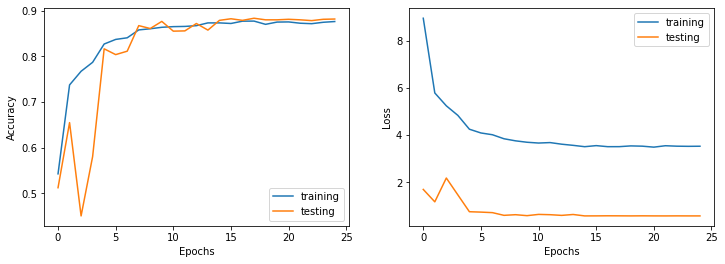

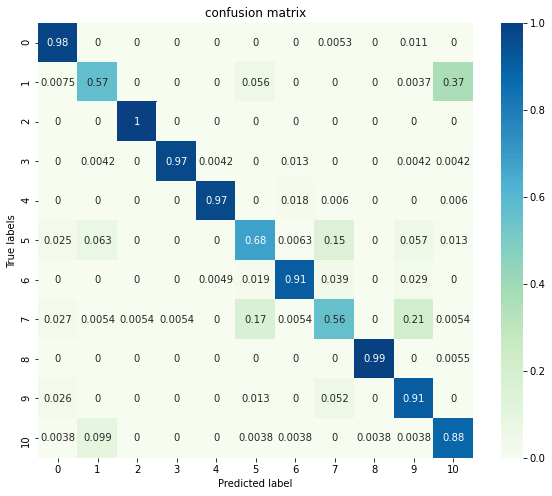

In [74]:
plot_hist(hist);
plot_confusion_matrix(df_pred)

In [69]:
pd.DataFrame.from_dict(classification_report(df_pred['true'], 
                                             df_pred['pred'], 
                                             target_names=testing_set.class_indices,
                                             output_dict=True)).transpose()

,precision,recall,f1-score,support
BA,0.930000,0.984127,0.956298,189.000000
BNE,0.800000,0.567164,0.663755,268.000000
EO,0.997691,1.000000,0.998844,432.000000
ERB,0.995671,0.970464,0.982906,237.000000
LY,0.987879,0.970238,0.978979,168.000000
MMY,0.670807,0.683544,0.677116,158.000000
MO,0.954082,0.907767,0.930348,206.000000
MY,0.730496,0.559783,0.633846,184.000000
PLT,0.997238,0.994490,0.995862,363.000000
PMY,0.542636,0.909091,0.679612,77.000000


## Visualise images and attention

### load model

In [16]:
trained_model = keras.models.load_model('results/results_2L/')
# model = model_surgery(trained_model)

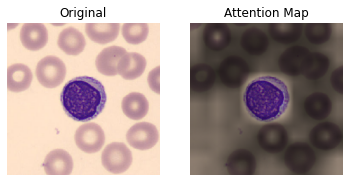

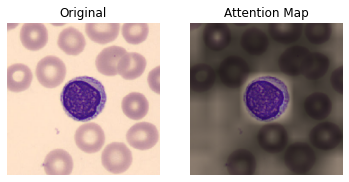

In [22]:
x = testing_set.next()
image = x[0][5]

plot_attention(image, trained_model)
plot_attention(image, vit_model);

# Head only
## History and conf_matrix

In [78]:
#history load
with open('results/head_only/training_hist_b16', 'rb') as f:
    hist = pickle.load(f) 

FileNotFoundError: [Errno 2] No such file or directory: 'results/head_only/training_hist_b16'

In [77]:
df_pred = pd.read_pickle('results/head_only/pred_b16.pk')
df_pred.img_path = df_pred.img_path.str.replace('../input/main-dataset/', '../../../data/') # local path

FileNotFoundError: [Errno 2] No such file or directory: 'results/head_only/pred_b16.pk'

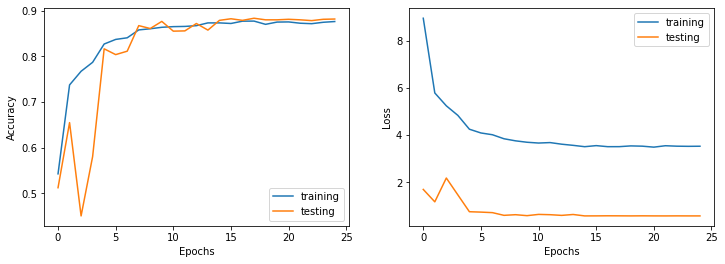

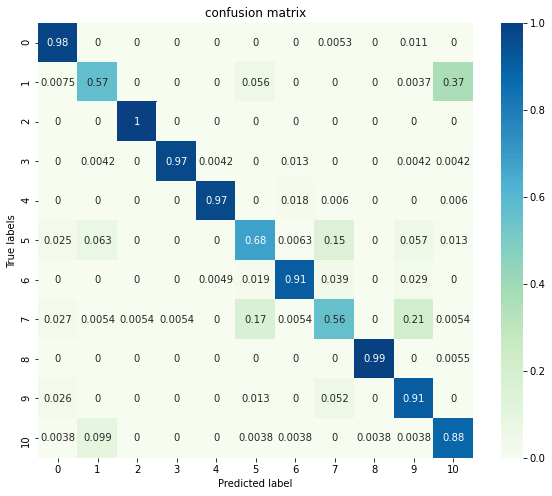

In [74]:
plot_hist(hist);
plot_confusion_matrix(df_pred)

In [69]:
pd.DataFrame.from_dict(classification_report(df_pred['true'], 
                                             df_pred['pred'], 
                                             target_names=testing_set.class_indices,
                                             output_dict=True)).transpose()

,precision,recall,f1-score,support
BA,0.930000,0.984127,0.956298,189.000000
BNE,0.800000,0.567164,0.663755,268.000000
EO,0.997691,1.000000,0.998844,432.000000
ERB,0.995671,0.970464,0.982906,237.000000
LY,0.987879,0.970238,0.978979,168.000000
MMY,0.670807,0.683544,0.677116,158.000000
MO,0.954082,0.907767,0.930348,206.000000
MY,0.730496,0.559783,0.633846,184.000000
PLT,0.997238,0.994490,0.995862,363.000000
PMY,0.542636,0.909091,0.679612,77.000000


## Visualise images and attention

### load model

/home/marie-anne/anaconda3/envs/DStest/lib/python3.9/site-packages/tensorflow_addons/activations/gelu.py:79: UserWarning: Default value of `approximate` is changed from `True` to `False`
  warnings.warn(


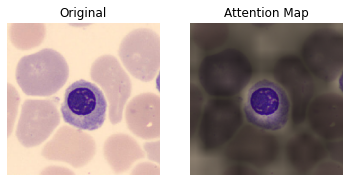

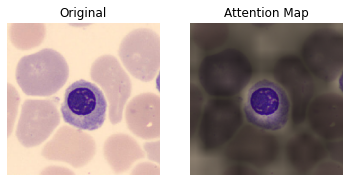

In [581]:
trained_model = keras.models.load_model('results/head_only/')
# model = model_surgery(trained_model)

x = testing_set.next()
image = x[0][6]

plot_attention(image, trained_model)
plot_attention(image, vit_model);

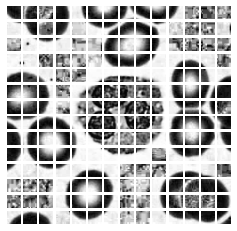

In [102]:
img = leuko.load_image(df_test.img_path[0], as_grey = True)[..., np.newaxis]
img  = tf.image.resize(tf.convert_to_tensor([img]), size=(IMG_SIZE, IMG_SIZE)
)

patched = tf.image.extract_patches(img,
                         sizes=[1, 16, 16, 1], 
                         strides=[1, 16, 16, 1],
                         rates=[1, 1, 1, 1],
                         padding="VALID",
                        )

patches = tf.reshape(patched, [img.shape[0], -1, patched.shape[-1]])

n = int(np.sqrt(patches.shape[1]))

plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (16, 16, 1))
    plt.imshow(patch_img,cmap='gray')
    plt.axis('off')

In [569]:
def get_img_array(img_path: str, dim: tuple) -> np.ndarray:
    img = tf.keras.preprocessing.image.load_img(Path(img_path), target_size = dim)
    array = tf.keras.preprocessing.image.img_to_array(img)
    array = np.expand_dims(img, axis = 0)
    return array, img

def make_gradcam_heatmap(img_array: np.ndarray, model, layer_name: str):
    
    for layer in reversed(model.layers):
        if layer_name in layer.name:
            last_conv_layer = model.get_layer(layer.name)
            break

    grad_model = tf.keras.models.Model(
        [model.inputs], 
        [last_conv_layer.output,  model.output])

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))

    last_conv_layer_output = last_conv_layer_output#[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)[1:]
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def gradcam(img_path: str, img_size: int, model: Model, layer_name: str) -> 'image':
    
    arr, img = get_img_array(img_path, (img_size, img_size))
    img = tf.keras.preprocessing.image.img_to_array(img)

    heatmap = make_gradcam_heatmap(arr, model, layer_name)
    heatmap = np.uint8(255 * heatmap)
    heatmap = np.reshape(heatmap, (14,14))
    jet = cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[..., :-1]
    jet_heatmap = jet_colors[heatmap]


    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * 0.8 + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
    
    return superimposed_img

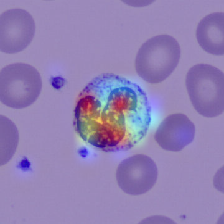

In [587]:
gradcam(df_test.img_path[7], IMG_SIZE, trained_model, 'encoder_norm')

In [371]:

import cv2



def attention_map(model, image):
    """Get an attention map for an image and model using the technique
    described in Appendix D.7 in the paper (unofficial).
    Args:
        model: A ViT model
        image: An image for which we will compute the attention map.
    """
    size = model.input_shape[1]
    grid_size = int(np.sqrt(model.layers[5].output_shape[0][-2] - 1))

    # Prepare the input
#     X = vit.preprocess_inputs(cv2.resize(image, (size, size)))[np.newaxis, :]  # type: ignore

    # Get the attention weights from each transformer.
    outputs = [
        l.output[1] for l in model.layers if isinstance(l, layers.TransformerBlock)
    ]
    weights = np.array(
        tf.keras.models.Model(inputs=model.inputs, outputs=outputs).predict(X)
    )
    num_layers = weights.shape[0]
    num_heads = weights.shape[2]
    reshaped = weights.reshape(
        (num_layers, num_heads, grid_size ** 2 + 1, grid_size ** 2 + 1)
    )

    # From Appendix D.6 in the paper ...
    # Average the attention weights across all heads.
    reshaped = reshaped.mean(axis=1)

    # From Section 3 in https://arxiv.org/pdf/2005.00928.pdf ...
    # To account for residual connections, we add an identity matrix to the
    # attention matrix and re-normalize the weights.
    reshaped = reshaped + np.eye(reshaped.shape[1])
    reshaped = reshaped / reshaped.sum(axis=(1, 2))[:, np.newaxis, np.newaxis]

    # Recursively multiply the weight matrices
    v = reshaped[-1]
    for n in range(1, len(reshaped)):
        v = np.matmul(v, reshaped[-1 - n])

    # Attention from the output token to the input space.
    mask = v[0, 1:].reshape(grid_size, grid_size)
    mask = cv2.resize(mask / mask.max(), (image.shape[1], image.shape[0]))[
        ..., np.newaxis
    ]
    return (mask * image).astype("uint8")
